Objetivo de este modelo base: El objetivo de este proyecto es desarrollar un modelo de predicción de precios de Bitcoin con métodos de aprendizaje automático utilizando datos de series temporales. Empleando algoritmos como la regresión lineal y las máquinas de soporte vectorial (SVM) con diferentes funciones de núcleo y parámetros, el proyecto busca identificar el modelo que minimice el error en la predicción de precios de cierre de Bitcoin.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Aprendizaje Máquina/Tarea Académica - ML/Proyecto final/bitcoin_2017_to_2023.csv', parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

In [3]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

In [37]:
df_daily = pd.read_csv('/content/drive/MyDrive/Aprendizaje Máquina/Tarea Académica - ML/Proyecto final/bitcoin_2017_to_2023.csv', parse_dates=['timestamp'])
df_daily.set_index('timestamp', inplace=True)

daily_data = df_daily.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'quote_asset_volume': 'sum',
    'number_of_trades': 'sum',
    'taker_buy_base_asset_volume': 'sum',
    'taker_buy_quote_asset_volume': 'sum'
})

print(daily_data.head())


               open     high      low    close       volume  \
timestamp                                                     
2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377   
2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264   
2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763   
2017-08-20  4139.98  4211.08  4032.62  4086.29   467.083022   
2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060   

            quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
timestamp                                                                       
2017-08-17        3.454770e+06              3427                   616.248541   
2017-08-18        5.086958e+06              5233                   972.868710   
2017-08-19        1.549484e+06              2153                   274.336042   
2017-08-20        1.930364e+06              2321                   376.795947   
2017-08-21        2.797232e+06              3972                   557.3

In [39]:
#daily_data['day_of_week'] = daily_data.index.dayofweek

In [40]:
start_date = pd.to_datetime('2017-08-17')
training_period = timedelta(days=365 + 182)

training_sets = []
validation_sets = []

current_start_date = start_date
while current_start_date + training_period < daily_data.index[-1]:
    train_end_date = current_start_date + training_period
    train_set = daily_data[(daily_data.index >= current_start_date) & (daily_data.index < train_end_date)]

    val_start_date = train_end_date
    val_end_date = val_start_date + timedelta(days=30)
    val_set = daily_data[(daily_data.index >= val_start_date) & (daily_data.index < val_end_date)]

    training_sets.append(train_set)
    validation_sets.append(val_set)

    current_start_date = val_start_date

print("Primer conjunto de entrenamiento:")
print(training_sets[0].head())

print(validation_sets[0].head())

Primer conjunto de entrenamiento:
               open     high      low    close       volume  \
timestamp                                                     
2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377   
2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264   
2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763   
2017-08-20  4139.98  4211.08  4032.62  4086.29   467.083022   
2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060   

            quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
timestamp                                                                       
2017-08-17        3.454770e+06              3427                   616.248541   
2017-08-18        5.086958e+06              5233                   972.868710   
2017-08-19        1.549484e+06              2153                   274.336042   
2017-08-20        1.930364e+06              2321                   376.795947   
2017-08-21        2.797232e+06        

In [41]:
len(training_sets)

3

In [55]:
X_train = training_sets[0][['open', 'high', 'low', 'volume', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']]
y_train = training_sets[0]['close'].shift(-1)

In [56]:
X_test = validation_sets[0][['open', 'high', 'low', 'volume', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']]
y_test = validation_sets[0]['close'].shift(-1)

In [57]:
X_train = X_train[:-1]
y_train = y_train[:-1]

In [58]:
X_test = X_test[:-1]
y_test = y_test[:-1]

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

In [61]:
X_train.shape

(546, 8)

In [62]:
X_test.shape

(29, 8)

In [63]:
svm_model = SVR(kernel='linear')
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

In [64]:
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)

In [65]:
print("Resultados de Regresión Lineal:")
print(f"MSE: {mse_linear:.2f}")
print(f"MAE: {mae_linear:.2f}\n")

Resultados de Regresión Lineal:
MSE: 9212.43
MAE: 57.55



In [66]:
print("Resultados de SVM:")
print(f"MSE: {mse_svm:.2f}")
print(f"MAE: {mae_svm:.2f}")

Resultados de SVM:
MSE: 2844178.77
MAE: 1683.13


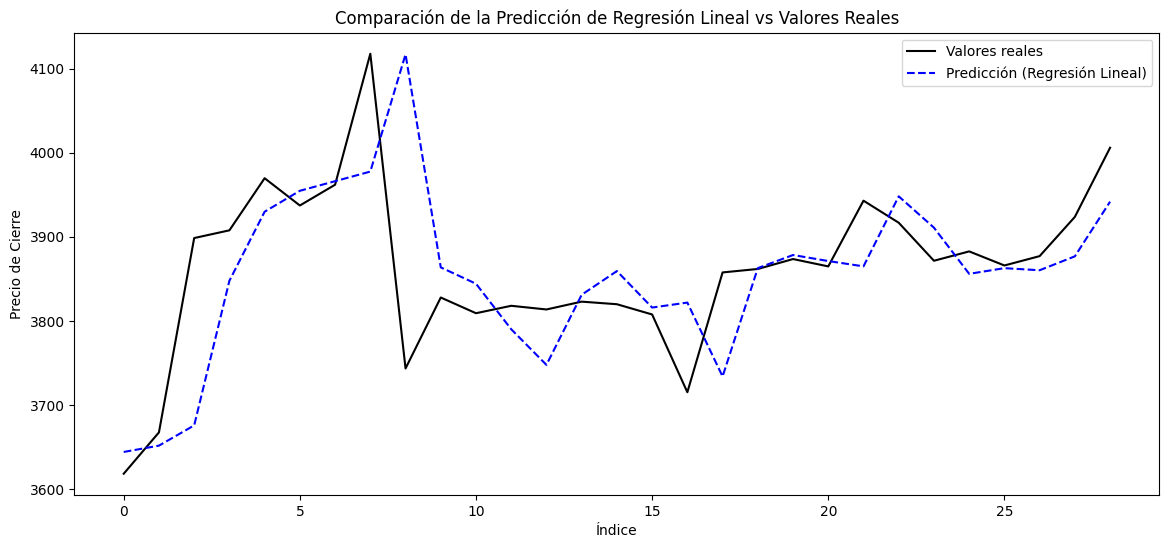

In [67]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_linear, label='Predicción (Regresión Lineal)', color='blue', linestyle='--')
plt.title('Comparación de la Predicción de Regresión Lineal vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

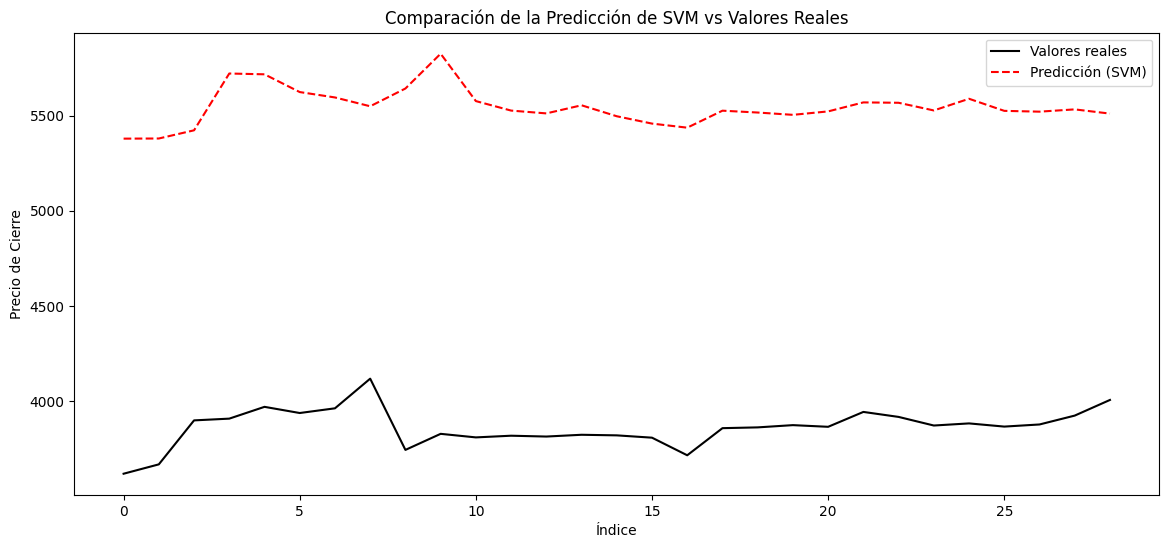

In [68]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_svm, label='Predicción (SVM)', color='red', linestyle='--')
plt.title('Comparación de la Predicción de SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

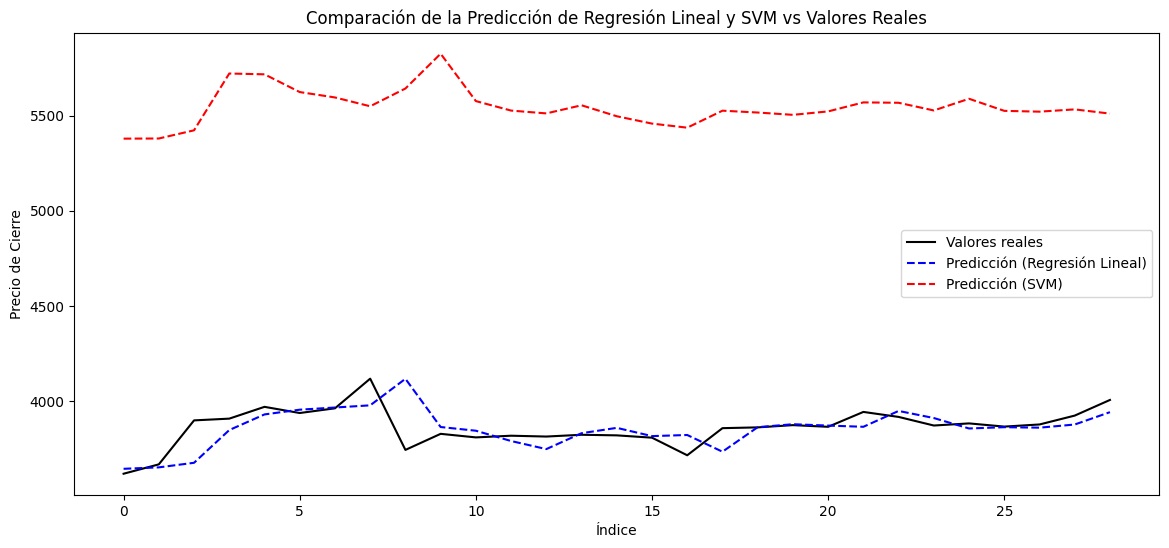

In [69]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_linear, label='Predicción (Regresión Lineal)', color='blue', linestyle='--')
plt.plot(y_pred_svm, label='Predicción (SVM)', color='red', linestyle='--')
plt.title('Comparación de la Predicción de Regresión Lineal y SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [70]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [71]:
param_grid = {
    'degree': [2, 3, 4],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1]
}

In [72]:
svm_poly_model = SVR(kernel='poly')

In [73]:
grid_search = GridSearchCV(estimator=svm_poly_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [74]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVR(kernel='poly'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4],
                         'epsilon': [0.01, 0.1, 0.5, 1]},
             scoring='neg_mean_squared_error')

In [75]:
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:")
print(best_params)

Mejores parámetros encontrados:
{'C': 10, 'degree': 3, 'epsilon': 0.01}


In [76]:
svm_poly_best_model = SVR(kernel='poly', degree=best_params['degree'], C=best_params['C'], epsilon=best_params['epsilon'])
svm_poly_best_model.fit(X_train_scaled, y_train)

SVR(C=10, epsilon=0.01, kernel='poly')

In [77]:
y_pred_svm_poly_best = svm_poly_best_model.predict(X_test_scaled)
mse_svm_poly_best = mean_squared_error(y_test, y_pred_svm_poly_best)
print(f"MSE del mejor modelo SVM polinomial: {mse_svm_poly_best:.2f}")

MSE del mejor modelo SVM polinomial: 4807740.54


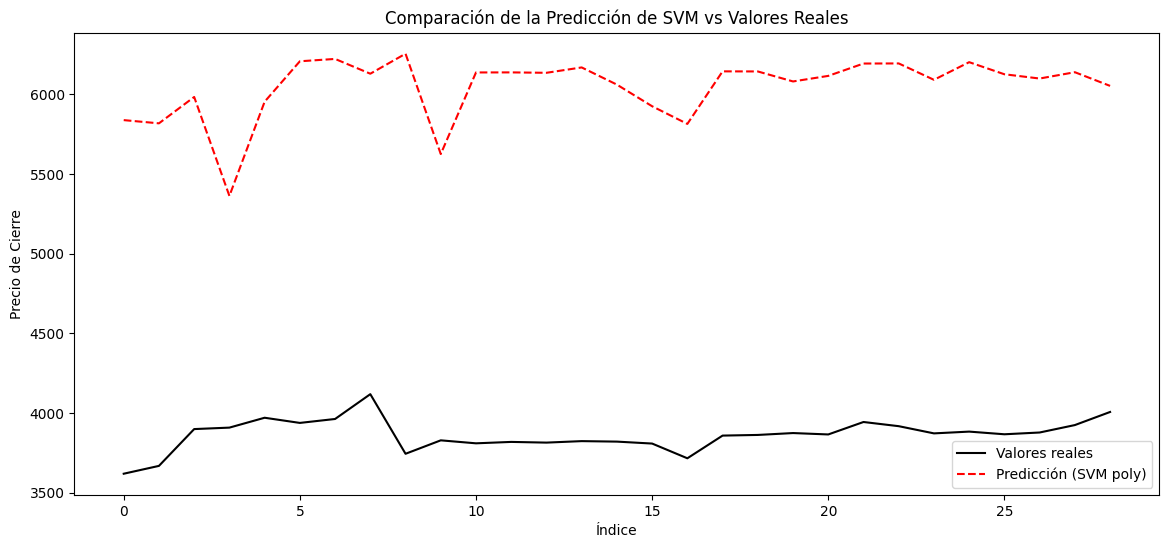

In [78]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_svm_poly_best, label='Predicción (SVM poly)', color='red', linestyle='--')
plt.title('Comparación de la Predicción de SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

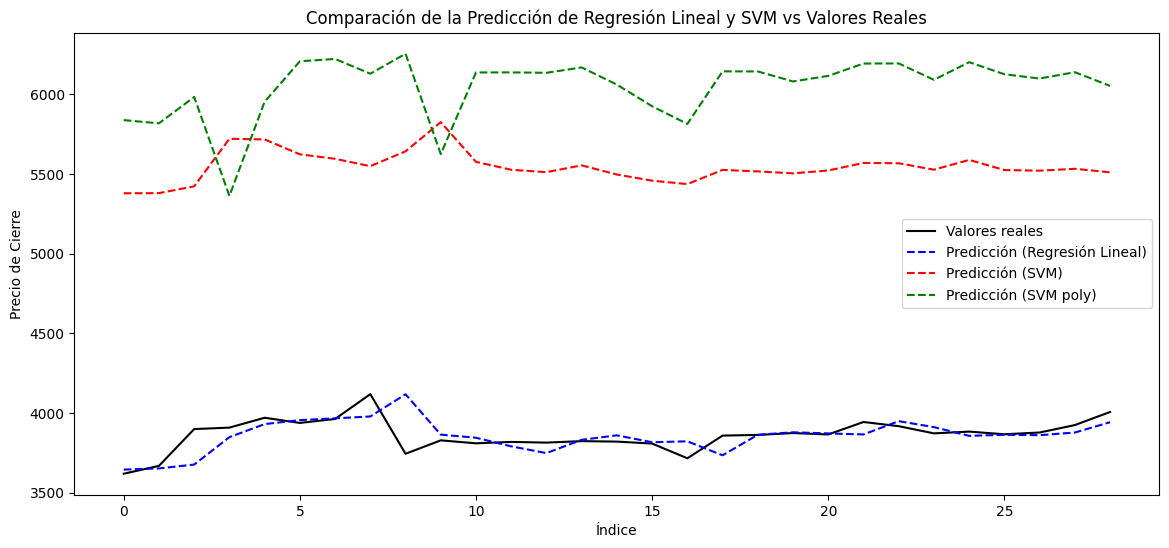

In [79]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_linear, label='Predicción (Regresión Lineal)', color='blue', linestyle='--')
plt.plot(y_pred_svm, label='Predicción (SVM)', color='red', linestyle='--')
plt.plot(y_pred_svm_poly_best, label='Predicción (SVM poly)', color='green', linestyle='--')
plt.title('Comparación de la Predicción de Regresión Lineal y SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [34]:
df_hourly = pd.read_csv('/content/drive/MyDrive/Aprendizaje Máquina/Tarea Académica - ML/Proyecto final/bitcoin_2017_to_2023.csv', parse_dates=['timestamp'])
df_hourly.set_index('timestamp', inplace=True)

hourly_data = df_hourly.resample('H').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'quote_asset_volume': 'sum',
    'number_of_trades': 'sum',
    'taker_buy_base_asset_volume': 'sum',
    'taker_buy_quote_asset_volume': 'sum'
})

print(hourly_data.head())

<ipython-input-34-e4d565fafb27>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = df_hourly.resample('H').agg({


                        open     high      low    close     volume  \
timestamp                                                            
2017-08-17 04:00:00  4261.48  4313.62  4261.32  4308.83  47.181009   
2017-08-17 05:00:00  4308.83  4328.69  4291.37  4315.32  23.234916   
2017-08-17 06:00:00  4315.32  4345.45  4309.37  4324.35   7.229691   
2017-08-17 07:00:00  4324.35  4349.99  4287.41  4349.99   4.443249   
2017-08-17 08:00:00  4333.32  4377.85  4333.32  4360.69   0.972807   

                     quote_asset_volume  number_of_trades  \
timestamp                                                   
2017-08-17 04:00:00       202366.138393               171   
2017-08-17 05:00:00       100304.823567               102   
2017-08-17 06:00:00        31282.312670                36   
2017-08-17 07:00:00        19241.058300                25   
2017-08-17 08:00:00         4239.503586                28   

                     taker_buy_base_asset_volume  taker_buy_quote_asset_volume  


In [35]:
hourly_data['hour'] = hourly_data.index.hour

In [136]:
start_date = pd.to_datetime('2017-08-17')
training_period = timedelta(days=365 + 182)

training_sets = []
validation_sets = []

current_start_date = start_date
while current_start_date + training_period < hourly_data.index[-1]:
    train_end_date = current_start_date + training_period
    train_set = hourly_data[(hourly_data.index >= current_start_date) & (hourly_data.index < train_end_date)]

    val_start_date = train_end_date
    val_end_date = val_start_date + timedelta(days=30)
    val_set = hourly_data[(hourly_data.index >= val_start_date) & (hourly_data.index < val_end_date)]

    training_sets.append(train_set)
    validation_sets.append(val_set)

    current_start_date = val_start_date

print("Primer conjunto de entrenamiento:")
print(training_sets[0].head())

print(validation_sets[0].head())

Primer conjunto de entrenamiento:
                        open     high      low    close     volume  \
timestamp                                                            
2017-08-17 04:00:00  4261.48  4313.62  4261.32  4308.83  47.181009   
2017-08-17 05:00:00  4308.83  4328.69  4291.37  4315.32  23.234916   
2017-08-17 06:00:00  4315.32  4345.45  4309.37  4324.35   7.229691   
2017-08-17 07:00:00  4324.35  4349.99  4287.41  4349.99   4.443249   
2017-08-17 08:00:00  4333.32  4377.85  4333.32  4360.69   0.972807   

                     quote_asset_volume  number_of_trades  \
timestamp                                                   
2017-08-17 04:00:00       202366.138393               171   
2017-08-17 05:00:00       100304.823567               102   
2017-08-17 06:00:00        31282.312670                36   
2017-08-17 07:00:00        19241.058300                25   
2017-08-17 08:00:00         4239.503586                28   

                     taker_buy_base_asset_volum

In [137]:
len(training_sets[0])

13124

In [165]:
len(validation_sets[0])

714

In [140]:
print("Valores faltantes en training_sets:")
print(training_sets[0].isnull().sum())

Valores faltantes en training_sets:
open                            0
high                            0
low                             0
close                           0
volume                          0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
hour                            0
dtype: int64


In [139]:
training_sets[0] = training_sets[0].dropna()

In [141]:
print("Valores faltantes en validation_sets:")
print(validation_sets[0].isnull().sum())

Valores faltantes en validation_sets:
open                            6
high                            6
low                             6
close                           6
volume                          0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
hour                            0
dtype: int64


In [142]:
validation_sets[0] = validation_sets[0].dropna()

In [143]:
X_train = training_sets[0][['open', 'high', 'low', 'volume', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume','hour']]
y_train = training_sets[0]['close'].shift(-1)

In [144]:
X_test = validation_sets[0][['open', 'high', 'low', 'volume', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume','hour']]
y_test = validation_sets[0]['close'].shift(-1)

In [145]:
print("Valores faltantes en X_train:")
print(X_train.isnull().sum())

Valores faltantes en X_train:
open                            0
high                            0
low                             0
volume                          0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
hour                            0
dtype: int64


In [149]:
print("Valores faltantes en y_train:", y_train.isnull().sum())

Valores faltantes en y_train: 0


In [147]:
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]

In [151]:
print("Valores faltantes en y_test:", y_test.isnull().sum())

Valores faltantes en y_test: 0


In [150]:
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]

In [152]:
X_train.shape

(13055, 9)

In [153]:
y_train.shape

(13055,)

In [154]:
X_test.shape

(713, 9)

In [155]:
y_test.shape

(713,)

In [156]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [157]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

In [158]:
svm_model = SVR(kernel='linear')
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

In [159]:
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)

In [160]:
print("Resultados de Regresión Lineal:")
print(f"MSE: {mse_linear:.2f}")
print(f"MAE: {mae_linear:.2f}\n")

Resultados de Regresión Lineal:
MSE: 385.66
MAE: 10.81



In [161]:
print("Resultados de SVM:")
print(f"MSE: {mse_svm:.2f}")
print(f"MAE: {mae_svm:.2f}")

Resultados de SVM:
MSE: 455.22
MAE: 12.28


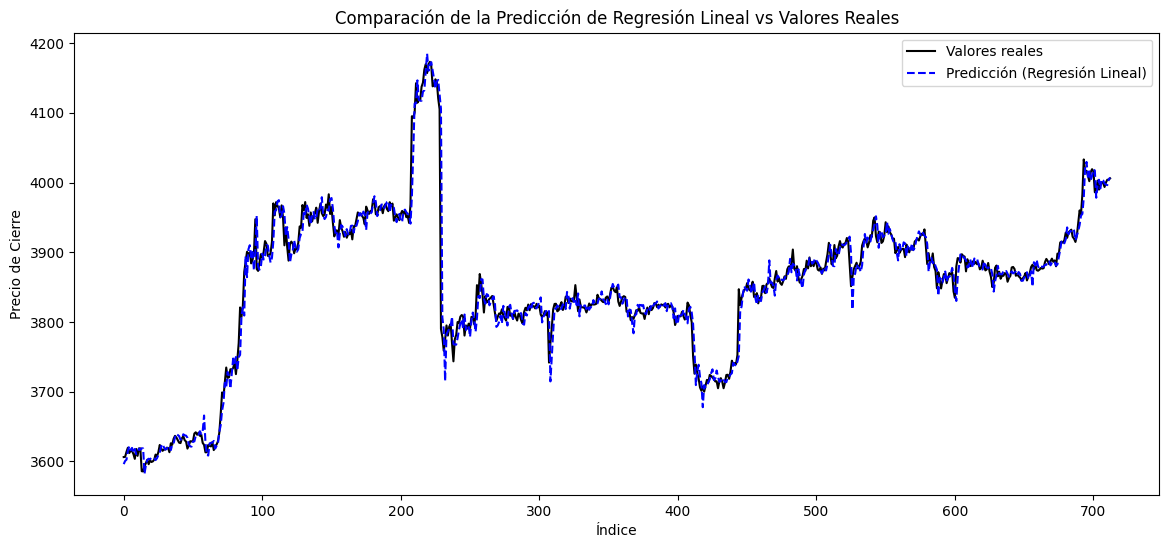

In [162]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_linear, label='Predicción (Regresión Lineal)', color='blue', linestyle='--')
plt.title('Comparación de la Predicción de Regresión Lineal vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

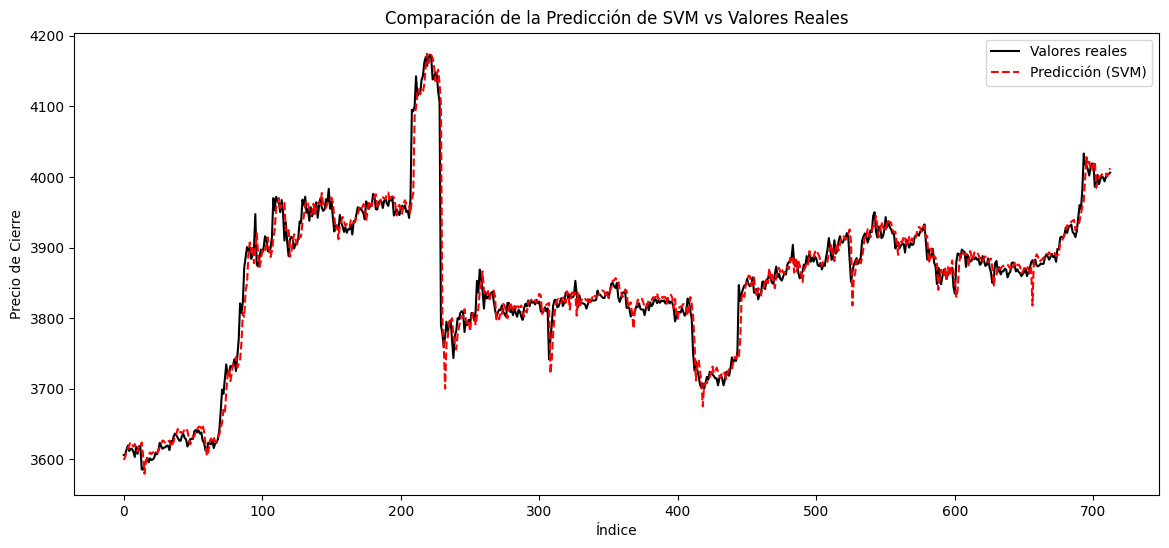

In [163]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_svm, label='Predicción (SVM)', color='red', linestyle='--')
plt.title('Comparación de la Predicción de SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

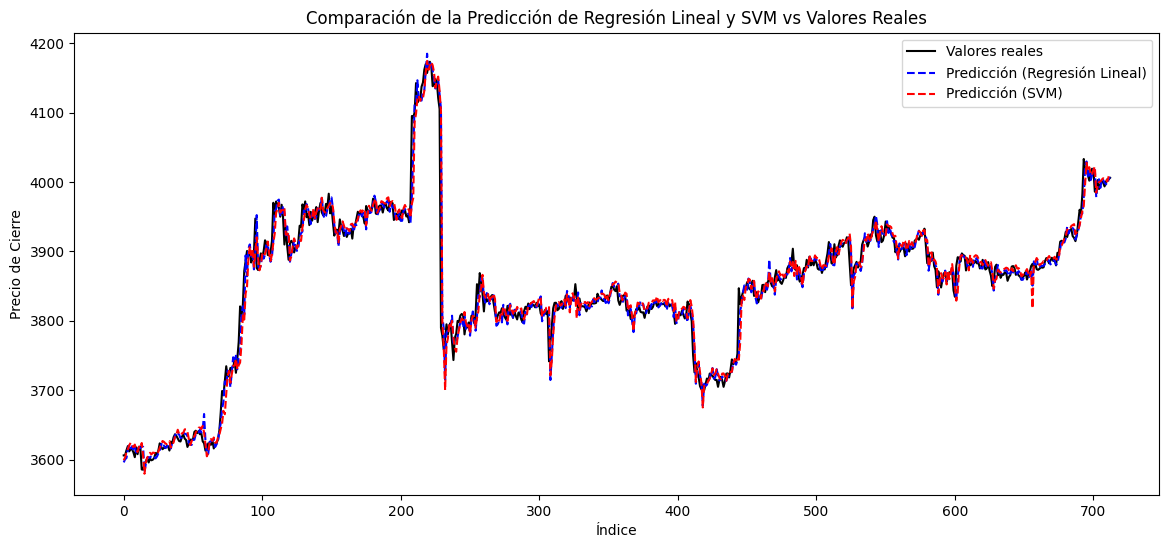

In [167]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_linear, label='Predicción (Regresión Lineal)', color='blue', linestyle='--')
plt.plot(y_pred_svm, label='Predicción (SVM)', color='red', linestyle='--')
plt.title('Comparación de la Predicción de Regresión Lineal y SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [168]:
param_grid = {
    'degree': [2, 3, 4],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1]
}

In [169]:
svm_poly_model = SVR(kernel='poly')

In [170]:
grid_search = GridSearchCV(estimator=svm_poly_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [171]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVR(kernel='poly'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4],
                         'epsilon': [0.01, 0.1, 0.5, 1]},
             scoring='neg_mean_squared_error')

In [172]:
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:")
print(best_params)

Mejores parámetros encontrados:
{'C': 1, 'degree': 3, 'epsilon': 0.01}


In [173]:
svm_poly_best_model = SVR(kernel='poly', degree=best_params['degree'], C=best_params['C'], epsilon=best_params['epsilon'])
svm_poly_best_model.fit(X_train_scaled, y_train)

SVR(C=1, epsilon=0.01, kernel='poly')

In [174]:
y_pred_svm_poly_best = svm_poly_best_model.predict(X_test_scaled)
mse_svm_poly_best = mean_squared_error(y_test, y_pred_svm_poly_best)
print(f"MSE del mejor modelo SVM polinomial: {mse_svm_poly_best:.2f}")

MSE del mejor modelo SVM polinomial: 4910131.92


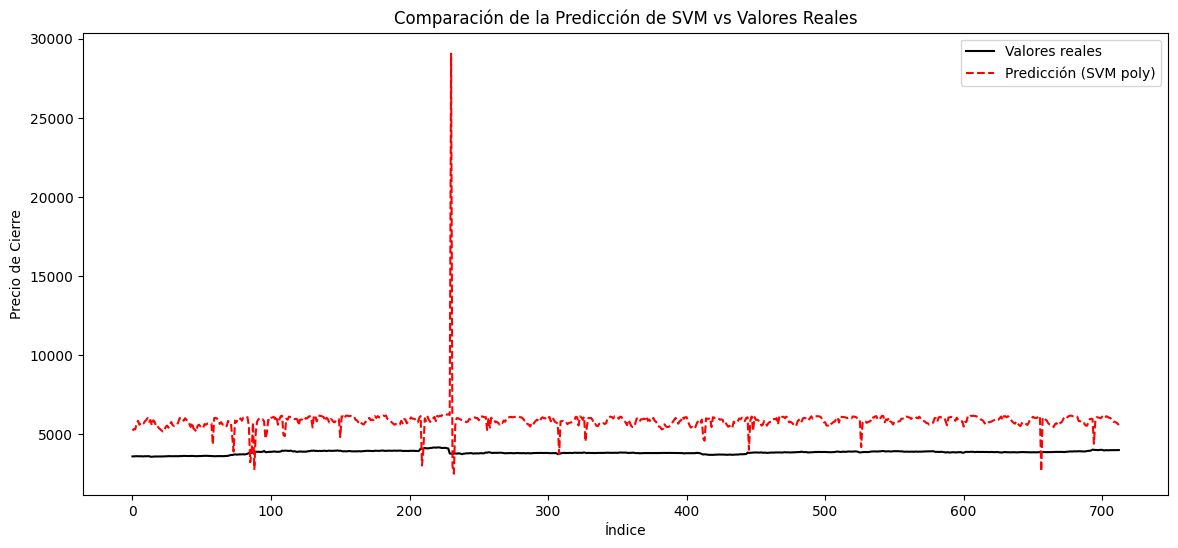

In [175]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_svm_poly_best, label='Predicción (SVM poly)', color='red', linestyle='--')
plt.title('Comparación de la Predicción de SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

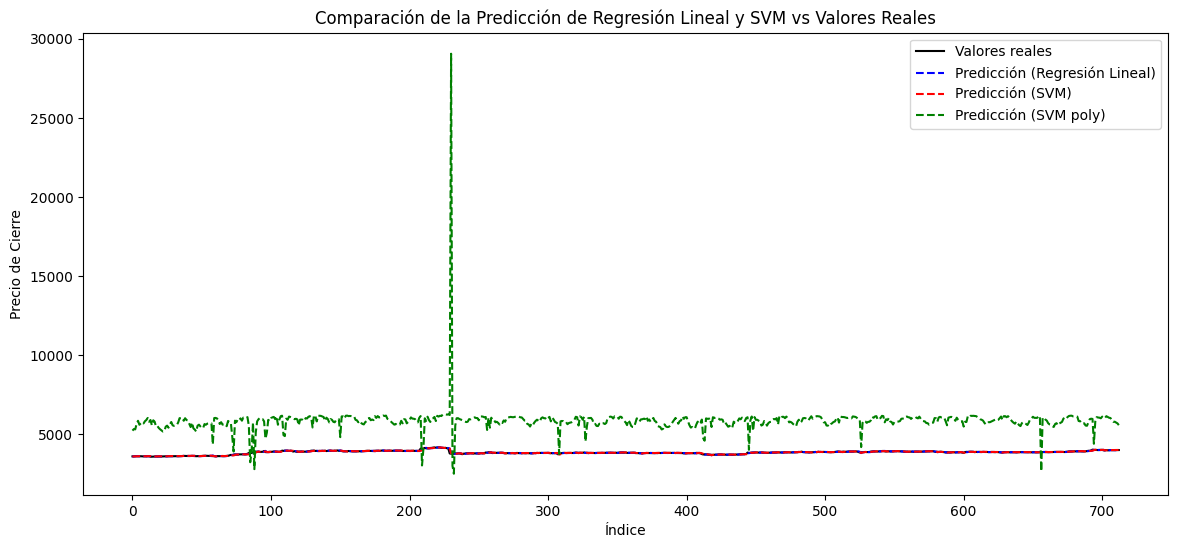

In [176]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_linear, label='Predicción (Regresión Lineal)', color='blue', linestyle='--')
plt.plot(y_pred_svm, label='Predicción (SVM)', color='red', linestyle='--')
plt.plot(y_pred_svm_poly_best, label='Predicción (SVM poly)', color='green', linestyle='--')
plt.title('Comparación de la Predicción de Regresión Lineal y SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [180]:
df = pd.read_csv('/content/drive/MyDrive/Aprendizaje Máquina/Tarea Académica - ML/Proyecto final/bitcoin_2017_to_2023.csv', parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

In [181]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

In [185]:
df.head()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836,13,1,1,8
2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195,13,1,1,8
2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121,13,1,1,8
2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916,13,1,1,8
2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611,13,1,1,8


In [186]:
start_date = pd.to_datetime('2017-08-17')
training_period = timedelta(days=365 + 182)

training_sets = []
validation_sets = []

train_period = timedelta(days=5 * 30)
val_period = timedelta(days=30)

start_date = df.index.min()

while start_date + train_period + val_period <= df.index.max():
    train_end_date = start_date + train_period
    train_set = df[(df.index >= start_date) & (df.index < train_end_date)]

    val_start_date = train_end_date
    val_end_date = val_start_date + val_period
    val_set = df[(df.index >= val_start_date) & (df.index < val_end_date)]

    training_sets.append(train_set)
    validation_sets.append(val_set)

    start_date = val_start_date

print("Primer conjunto de entrenamiento:")
print(training_sets[0].head())

print("\nPrimer conjunto de validación:")
print(validation_sets[0].head())

Primer conjunto de entrenamiento:
                         open      high       low     close    volume  \
timestamp                                                               
2018-01-14 03:59:00  14160.00  14165.00  14160.00  14162.00  1.044041   
2018-01-14 03:58:00  14151.01  14165.00  14150.00  14165.00  0.636367   
2018-01-14 03:57:00  14170.00  14172.85  14151.01  14151.01  1.267389   
2018-01-14 03:56:00  14169.00  14170.00  14150.01  14170.00  1.101939   
2018-01-14 03:55:00  14148.88  14169.99  14135.30  14169.99  9.374651   

                     quote_asset_volume  number_of_trades  \
timestamp                                                   
2018-01-14 03:59:00        14785.902779                12   
2018-01-14 03:58:00         9009.546631                26   
2018-01-14 03:57:00        17957.797360                42   
2018-01-14 03:56:00        15612.113216                19   
2018-01-14 03:55:00       132647.692126                42   

                     taker

In [187]:
len(training_sets[0])

215775

In [188]:
len(validation_sets[0])

41140

In [190]:
print("Valores faltantes en training_sets:")
print(training_sets[0].isnull().sum())

Valores faltantes en training_sets:
open                            0
high                            0
low                             0
close                           0
volume                          0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
hour                            0
day_of_week                     0
day_of_month                    0
month                           0
dtype: int64


In [191]:
X_train = training_sets[0][['open', 'high', 'low', 'volume', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume','hour','day_of_week','day_of_month']]
y_train = training_sets[0]['close'].shift(-1)

In [192]:
X_test = validation_sets[0][['open', 'high', 'low', 'volume', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume','hour','day_of_week','day_of_month']]
y_test = validation_sets[0]['close'].shift(-1)

In [193]:
X_train = X_train[:-1]
y_train = y_train[:-1]

In [194]:
X_test = X_test[:-1]
y_test = y_test[:-1]

In [195]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [196]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

In [197]:
svm_model = SVR(kernel='linear')
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

In [203]:
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)

In [204]:
print("Resultados de Regresión Lineal:")
print(f"MSE: {mse_linear:.2f}")
print(f"MAE: {mae_linear:.2f}\n")

Resultados de Regresión Lineal:
MSE: 99.85
MAE: 6.57



In [205]:
print("Resultados de SVM:")
print(f"MSE: {mse_svm:.2f}")
print(f"MAE: {mae_svm:.2f}")

Resultados de SVM:
MSE: 180.27
MAE: 9.32


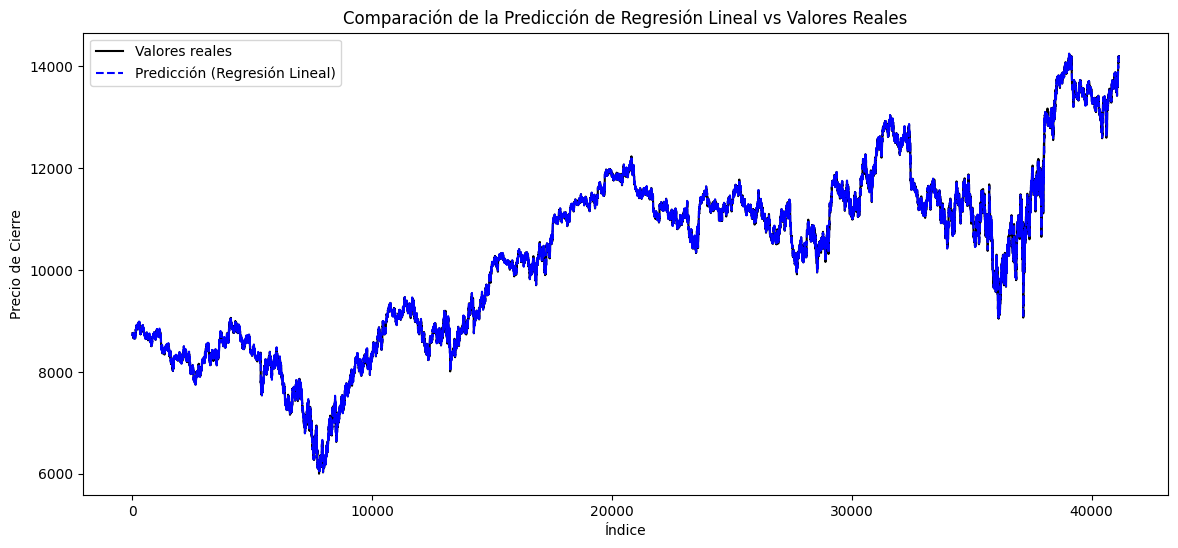

In [198]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_linear, label='Predicción (Regresión Lineal)', color='blue', linestyle='--')
plt.title('Comparación de la Predicción de Regresión Lineal vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

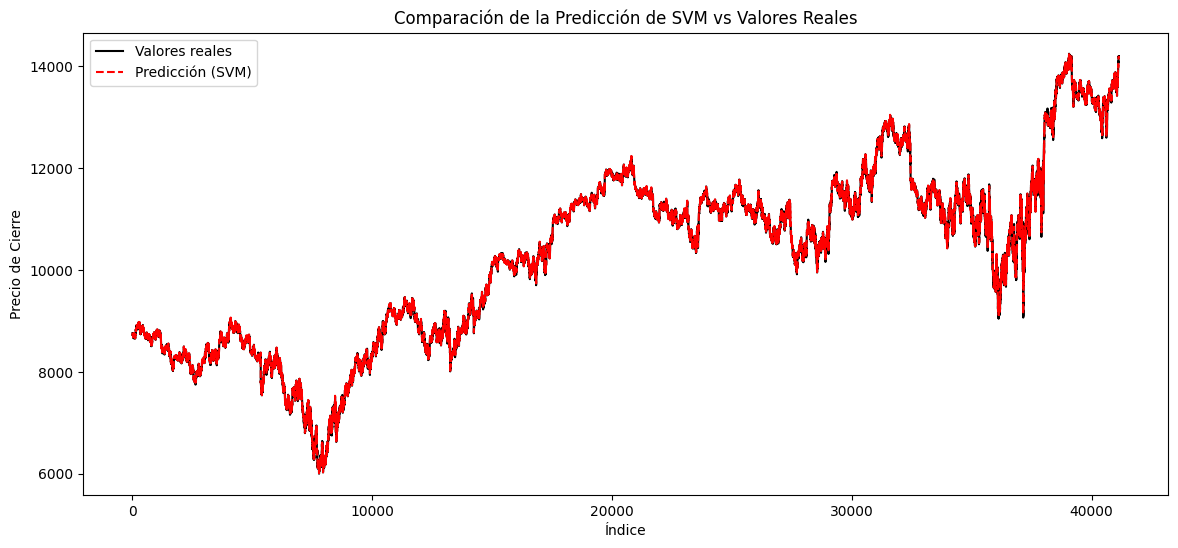

In [199]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_svm, label='Predicción (SVM)', color='red', linestyle='--')
plt.title('Comparación de la Predicción de SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

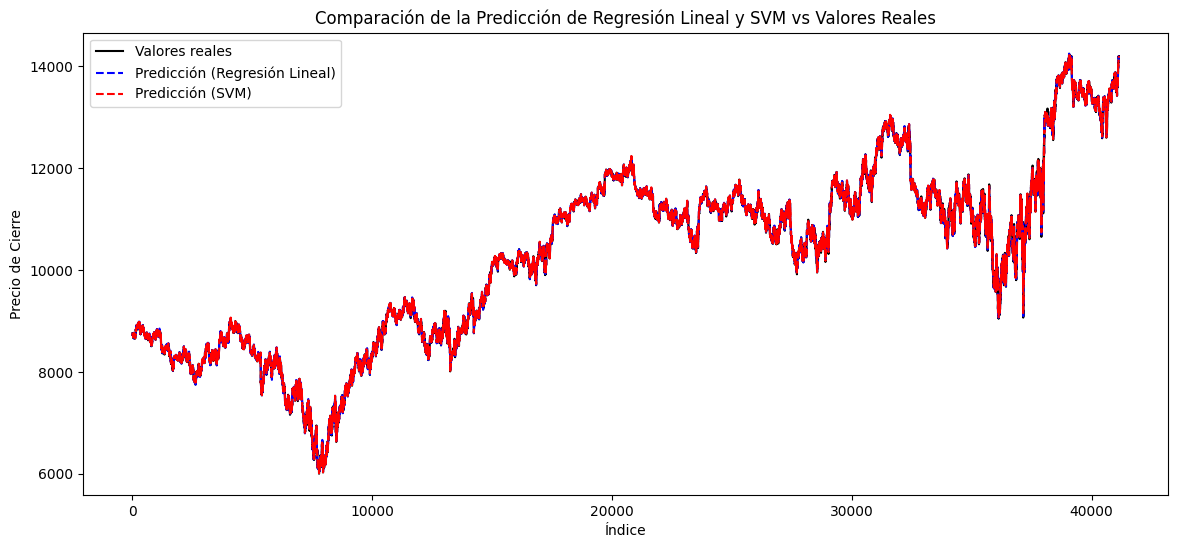

In [201]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_linear, label='Predicción (Regresión Lineal)', color='blue', linestyle='--')
plt.plot(y_pred_svm, label='Predicción (SVM)', color='red', linestyle='--')
plt.title('Comparación de la Predicción de Regresión Lineal y SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

###Exportar modelos

In [206]:
import joblib

In [207]:
models = {
    'linear_model': linear_model,
    'svm_model_linear': svm_model,
    'svm_model_poly': svm_poly_best_model
}

# Guardar cada modelo en un archivo .joblib
for model_name, model in models.items():
    joblib.dump(model, f'{model_name}.joblib')
    print(f'Modelo {model_name} exportado exitosamente como {model_name}.joblib')


Modelo linear_model exportado exitosamente como linear_model.joblib
Modelo svm_model_linear exportado exitosamente como svm_model_linear.joblib
Modelo svm_model_poly exportado exitosamente como svm_model_poly.joblib


In [208]:

loaded_linear_model = joblib.load('linear_model.joblib')
loaded_svm_model_linear = joblib.load('svm_model_linear.joblib')
loaded_svm_model_poly = joblib.load('svm_model_poly.joblib')

y_pred_loaded = loaded_linear_model.predict(X_test)


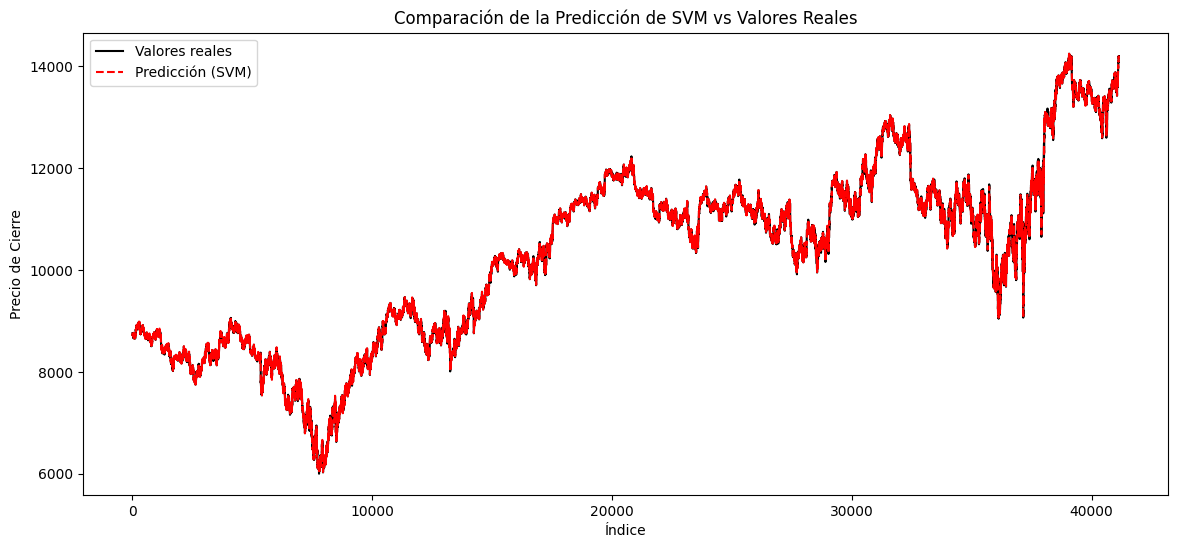

In [209]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_loaded, label='Predicción (SVM)', color='red', linestyle='--')
plt.title('Comparación de la Predicción de SVM vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [210]:
y_pred_loaded = loaded_linear_model.predict(X_test)

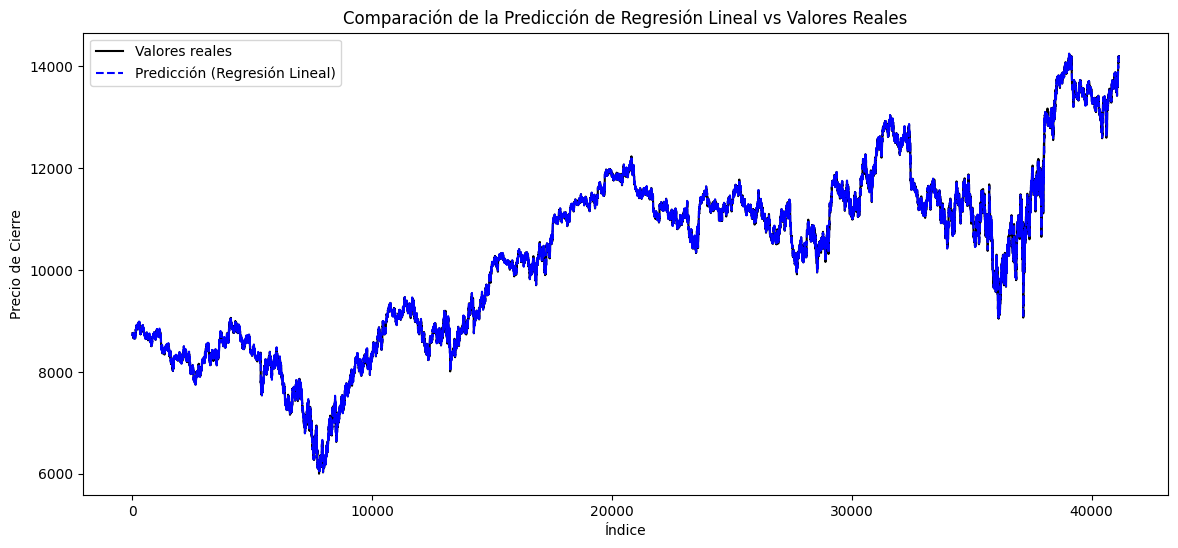

In [211]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Valores reales', color='black')
plt.plot(y_pred_linear, label='Predicción (Regresión Lineal)', color='blue', linestyle='--')
plt.title('Comparación de la Predicción de Regresión Lineal vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()